Проект ведётся в соответствии со стандартом [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)

# Анализ требований (Business Understanding)

**Бизнес-цель**: разработать модель, которая позволила бы агенству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

**Data-Science цель**: разработать регрессионную модель прогнозирования стоимости жилья для агенства недвижимости, взяв за основу имеющийся [датасет](https://drive.google.com/file/d/11-ZNNIdcQ7TbT8Y0nsQ3Q0eiYQP__NIW/view?usp=share_link)
*(датасет также синхронизируется средствами DVC на google drive)*.

На этапе фактического внедрения модели необходимо прибегнуть к A/B-тестированию, сопоставив скорость и качество совершения сделок до внедрения модели и после интеграции модели прогнозирования стоимости жилья.
При этом уже сейчас можно было бы уточнить у заказчика, что он понимает под качеством совершения сделок, какие показатели у агенства сейчас и с какими конкурентами предполагается вести сравнение.

Ввиду отсутсвия на данный момент этой информации, можно предположить, что агенство недвижимости хочет максимизировать среднее отношение стоимости сделки $\text{Value}_\text{trans}$ ко времени совершения этой сделки $t_\text{trans}$ (*trans* от англ. *transaction*):

$$
    \mathbb{E}\left(\frac{\text{Value}_\text{trans}}{t_\text{trans}}\right) \rightarrow \text{max}
$$

Осуществить это можно, максимизируя точность предсказательной модели, так как при предсказании справедливой цены можно значительно ускорить завершение сделки (снизить $t_\text{trans}$), не потеряв, и, возможно, даже увеличив $\text{Value}_\text{trans}$, предотвращая демпинг цены на недвижимость.

Таким образом, это задача *регрессии*, для которой можно ввести следующие метрики качества модели, с учётом наличия истинных значений стоимости (обучение с учителем):
- Средняя абсолютная ошибка, выраженная в процентах (**MAPE**);
- Коэффициент детерминации (**$R^2$**).

Первая метрика позволит оценить, на сколько процентов в среднем предсказание отклоняется от реального значения.
Будем её использовать, так как нет сведений о том, какое значение целевого показателя считать приемлемым.

Вторая метрика покажет, насколько модель лучше, чем если бы все предсказания были бы средним по правильным ответам. 
То есть показывает, какую долю информации о зависимости (дисперсии) смогла уловить модель.

Однако, необходимо прежде оценить распределение целевого признака, может полезно прибегнуть к логарифмическим метрикам.

## Задачи

1. Провести разведывательный анализ (EDA) и очистку исходных данных.
Во многих признаках присутствуют дублирующиеся категории, ошибки ввода, жаргонные сокращения и так далее.
Необходимо отыскать закономерности, расшифровать все сокращения, найти синонимы в данных, обработать пропуски и удалить выбросы.

2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости (Data Preparation)

3. Построить модель для прогнозирования стоимости недвижимости.

4. Разработать веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.


## Описание данных
- `status` — статус продажи;
- `private pool` и `PrivatePool` — наличие собственного бассейна;
- `propertyType` — тип объекта недвижимости;
- `street` — адрес объекта;
- `baths` — количество ванных комнат;
- `homeFacts` — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
- `fireplace` — наличие камина;
- `city` — город;
- `schools` — сведения о школах в районе;
- `sqft` — площадь в футах;
- `zipcode` — почтовый индекс;
- `beds` — количество спален;
- `state` — штат;
- `stories` — количество этажей;
- `mls-id` и `MlsId` — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
- `target` — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

## Сведения о данных

1. Признаки `homeFacts` и `schools` представляют собой словари и
содержат несколько типов сведений. Необходимо десериализовать
содержимое этих признаков. Если в нём есть полезные данные,
необходимо создать из них новые признаки.

2. [Типы жилья и их основные характеристики](https://www.rocketmortgage.com/learn/types-of-houses)
(пригодится при обработке признака `propertyType`):
- apartment — съёмная квартира (нельзя купить);
- condo — кондоминиум (можно купить);
- co-op — квартира в жилищном кооперативе;
- single-family (detached, tiny home) — односемейный (отдельный,
маленький) дом;
- townhome, townhouse — таунхаус;
- cape cod — черепичная крыша, облицовка деревянным сайдингом,
дверь в центре здания, окна по бокам, один-два этажа;
- colonial home — минимум два этажа, симметрия, лестница в центре
здания, строгий внешний вид;
- contemporary — чистые, простые линии, нейтральные цвета, натуральные
текстуры;
- cottage — небольшая уютная веранда, небольшие жилые помещения;
- craftsman — деревянные элементы ручной работы, выступающие балки,
большие колонны;
- Greek revival — большие белые колонны, украшения в греческом стиле,
нарядный вход;
- farmhouse — прямоугольная планировка, большое крыльцо, амбарная
крыша;
- French country — влияние прованса, облицовка камнем, состаренный
вид;
- Mediterranean — белая штукатурка, дерево и камень в тёплых тонах,
черепичные крыши, элементы испанских и итальянских вилл;
- midcentury modern — сочетание плавных природных и строгих
геометрических линий, гладкость, лаконичность, большие окна;
- ranch — один этаж, низкая крыша, открытые жилые помещения, задний
двор;
- split-level — жилые помещения разделены короткими лестничными
пролётами;
- Tudor — деревянные балки, каменная кладка, асимметричная крутая
двускатная крыша;
- Victorian (Queen Anne Houses) — два-три и более этажей, богатый декор,
крутая двускатная крыша, небольшие башенки, яркий фасад;
- European Houses style — кирпич или камень, высокая крутая крыша,
высокие окна, часто со ставнями, традиционные декоративные детали
(фронтоны, замковые камни);
- log home — деревянный дом.

3. Некоторые жаргонные сокращения — для исправления дублирования
(пригодится при обработке признака `propertyType`):
- 'manufactured home (house)' = 'mobile' = 'prefab' = 'modular';
- 'mobile' = 'mo2 le' = 'mo2le';
- 'cabin' = 'ca2 n' = 'ca2n';
- midcentury = mid century = mid-century;
- single family = single-family home.

4. Некоторые термины, используемые в сфере купли-продажи
недвижимости:
- status — статус, состояние.
- estate — объект недвижимости.
- 'foreclosed' ('foreclosure') — «лишён права выкупа».
Это процесс, когда недвижимость переходит к кредитору из-за
неуплаты ипотеки заёмщиком. Продажа foreclosure-недвижимости
отличается от традиционных продаж.
- 'pre foreclosure' ('pre foreclosure auction') — «до выкупа»,
«аукцион до выкупа».
- 'under contract showing' ('under contract show', 'under
contract', 'active under contract') — предложение о покупке
уже сделано, но не принято продавцом окончательно, и
недвижимость продолжают показывать другим потенциальным
покупателям.
- 'under contract backups', 'active backup', 'backup contract' —
предложение о покупке уже сделано и принято продавцом,
однако он открыт для резервных предложений.
- 'contingency' — дополнительные обстоятельства (критерии,
которым должен соответствовать продавец/покупатель до
завершения сделки).
- 'contingency contract' — контракт на случай возникновения
дополнительных обстоятельств.
- 'active contingency' — сделка уже практически состоялась,
однако продавцу/покупателю для её завершения необходимо
выполнить какие-то условия.
- 'insp inspection contingency' — ситуация, когда покупатель
может официально проинспектировать объект недвижимости в
определённый период времени.
- 'pending escape clause' — договор, предполагающий свободный
выход сторон из него.
- 'pending backup wanted' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям и принимать резервные
предложения.
- 'pending take backups' — условие, предполагающее, что
продавец может принимать резерные предложения, если сделка
с текущим покупателем не состоится.
- 'pending continue show' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям на случай, если текущая сделка не
состоится.
- 'pending inspection' — «в ожидании инспекции».
- 'due diligence period' — период, в течение которого покупатель
имеет право проинспектировать недвижимость и изучить всю
важную для заключения сделки информацию.
- 'activated' — «активен», открыт для покупки.
- 'active with contract' — продавец уже принял предложение о
покупке, однако сделка ещё не закрыта.
- 'active with offer' — продавец принял предложение о покупке,
однако ищет резервные предложения на случай, если сделка с
текущим покупателем не состоится.
- 'active auction', 'auction active', 'auction' — продажа
недвижимости с помощью аукциона.
- cooling-off period — период, в течение которого покупатель
может расторгнуть договор после завершения сделки.


# Импорт библиотек и данных

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.set_style('darkgrid')

from ydata_profiling import ProfileReport

from IPython.display import display, display_html, HTML

root_folder = '../'
sys.path.append(root_folder)
# from src.data import make_dataset
from src import utils
from src.features import build_features
from src.visualization import visualize

source_data = Path(root_folder, 'data', 'raw', 'data.csv')
export_path = Path(root_folder, 'data', 'interim', '1.0_first_process.csv')

In [2]:
raw_df = pd.read_csv(
    source_data
)
raw_df.info()
display(raw_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,"$1,249,000"
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,"$674,999"
377182,for sale,NaN,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,NaN,NaN,"$528,000"
377183,NaN,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,NaN,NaN,"$34,500"


# Первичный анализ и обработка данных (Data Understanding)

Проведём первичный анализ данных, используя `ydata_profiling` и выведенную информацию выше

In [3]:
profile_path = Path(root_folder, 'reports', 'init_profiling.html')

# Create init profiling report if it does not exist
if not os.path.isfile(profile_path):
    profile = ProfileReport(raw_df, title='House profiling')
    profile.to_file(profile_path)
    print('Save to:', profile_path)
print('See report in ', profile_path)

See report in  ../reports/init_profiling.html


Некоторые наблюдения:

- Имеется датасет из 377185 строк и 18 колонок
- Все колонки имеют тип "object" и требуют предобработки для того, чтобы получить численные значения, где они предполагаются
- Имеем дело с большим количеством пропусков в ряде колонок
- Имеются несколько дублирующихся строчек (порядка 49)
- Некоторые признаки дублируются
- Пропуски в `target` критичны для нас, поэтому имеет смысл удалить строки с пропусками в целевом признаке

Будем разбираться по-порядку, анализируя каждый признак по отдельности

## Target

Удалим строки с отсутствующим таргетом:

In [4]:
print(
    'Доля строк без таргета:', 
    utils.get_percentage(raw_df['target'].isna().sum(), raw_df.shape[0])
)
df = raw_df.dropna(subset=['target'])
df.shape

Доля строк без таргета: 0.658%


(374704, 18)

Приведём таргет к числовому типу. 
Для этого посмотрим на нечисловые символы

In [5]:
df['target'].str.findall(r'[^0-9]+').value_counts()

target
[$, ,]                  267483
[,]                      55868
[$, ,, ,]                33614
[,, ,]                   10001
[$, ,, +]                 6931
[$, ,, /mo]                373
[$, ,, ,, +]               332
[$]                         64
[$, /mo]                    24
[]                          13
[$, ,,  - $, ,, /mo]         1
Name: count, dtype: int64

- Кроме доллара, другие валюты не встречаются.
Положим, что все цены указаны в долларах, пока не выяснится, что это не так.
- Встречается "/mo", посмотрим ниже. Скорее всего речь идёт об аренде с помесячной оплатой.
- Используются запятые как разделители тысяч, их стоит исключить.
- Также встречается знак "+". Возможно, указывает, что это стартовая цена. Необходимо проверить.

Да, все объявления с ценой "/mo" это объявления о сдаче в аренду.
Так как это малая доля от сделок на продажу, удалим эти строки.

In [6]:
print('Статус для объявлений с помесячной оплатой:')
mo_mask = df['target'].str.contains('mo')
display(df[mo_mask]['status'].value_counts())
print(
    'Доля объявлений аренды:', 
    utils.get_percentage(mo_mask.sum(), df.shape[0])
)
df = df[~mo_mask]
df.shape

Статус для объявлений с помесячной оплатой:


status
for rent    398
Name: count, dtype: int64

Доля объявлений аренды: 0.106%


(374306, 18)

Посмотрим, есть ли какие-то особенности при указании "+"

In [7]:
plus_mask = df['target'].str.contains('\\+')
display(df[plus_mask])
print(
    'Доля объявлений со знаком "+" в цене:', 
    utils.get_percentage(plus_mask.sum(), df.shape[0])
)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
47,for sale,NaN,single-family home,Santa Rosa Plan in Twin Mills,2 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Fort Worth,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...","1,683 sqft",76179,3 Beds,TX,1,NaN,NaN,NaN,"$233,990+"
97,for sale,NaN,single-family home,Armstrong Plan in Cadence at Mint Hill,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Mint Hill,"[{'rating': ['5/10', '10/10', '6/10'], 'data':...","1,731 sqft",28227,2 Beds,NC,NaN,NaN,NaN,NaN,"$331,990+"
112,for sale,NaN,single-family home,Lantana ABC Plan in Freedom Hills,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['4/10', '3/10'], 'data': {'Distan...","1,709 sqft",78242,3 Beds,TX,1,NaN,NaN,NaN,"$201,990+"
124,for sale,NaN,single-family home,1848 Plan in Margaritaville Cottages Orlando,5.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Kissimmee,"[{'rating': ['6/10', '4/10'], 'data': {'Distan...","1,848 sqft",34747,5 Beds,FL,2.0,NaN,NaN,NaN,"$494,800+"
130,for sale,NaN,condo,Astor D Plan in The Grove,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Austin,"[{'rating': ['9/10', '6/10', '7/10'], 'data': ...","1,375 sqft",78703,2 Beds,TX,1.0,NaN,NaN,NaN,"$590,000+"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376851,for sale,NaN,townhouse,Chesters Plan in Waterford Park : Barrington &...,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['7/10', '8/10', 'None/10', 'None/...","1,034 sqft",78253,2 Beds,TX,1.0,NaN,yes,NaN,"$179,999+"
376909,for sale,NaN,townhouse,Giada Plan in Avesa,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Tampa,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...","2,262 sqft",33625,3 Beds,FL,2.0,NaN,yes,NaN,"$327,990+"
376966,for sale,NaN,single-family home,Sunnydale Plan in Fox Creek,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Jacksonville,"[{'rating': ['2/10', '4/10', '3/10'], 'data': ...","2,205 sqft",32222,4 Beds,FL,2,NaN,NaN,NaN,"$234,990+"
376972,for sale,NaN,townhouse,1566-3 Plan in The Villas at Del Sol,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Murfreesboro,"[{'rating': ['4/10', '8/10', '7/10'], 'data': ...","1,566 sqft",37127,3 Beds,TN,2.0,NaN,NaN,NaN,"$231,100+"


Доля объявлений со знаком "+" в цене: 1.940%


Так как доля объявлений со знаком "+" мала, не будем выделять отдельный признак под это.

Уберём теперь посторонние символы "$", "+", "," и преобразуем к численному признаку.

После чего посмотрим на распределение целевого признака

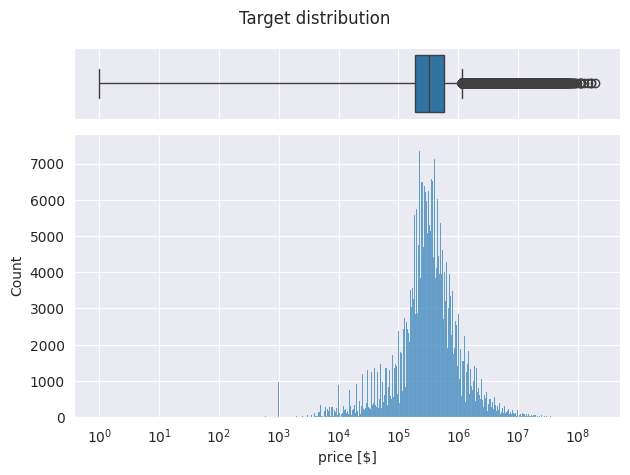

In [8]:
df['target'] = build_features.get_numerical_target(df['target'])

visualize.plot_box_hist_plot(
    df, 
    'target', 
    numeric_label='price [$]', 
    log_scale=True, 
    title='Target distribution',
);

График был построен в логарифмических координатах, так имеется большой разброс в стоимости жилья.
Больше половины объявлений имеют стоимость в диапазоне 100 000 - 1 000 000 $.
Расмотрим внимательнее выбросы.

In [9]:
display(HTML("<h2>Property type for low-cost"))
display(df[df['target'] < 1e5]['propertyType'].value_counts())
display(HTML("<h2>Property type for high-cost"))
display(df[df['target'] > 1e6]['propertyType'].value_counts())

propertyType
lot/land                10812
Land                     7304
single-family home       6581
Single Family            3285
Single Family Home       1967
                        ...  
Custom                      1
Multiplex, Ranch            1
English, Traditional        1
Other - See Remarks         1
Cottage/Camp                1
Name: count, Length: 166, dtype: int64

propertyType
single-family home                                                        9233
Single Family                                                             7099
condo                                                                     4286
Single Family Home                                                        2539
multi-family                                                              2437
                                                                          ... 
2 Stories, Traditional, Texas Hill Country                                   1
Single Detached, Contemporary/Modern, Other (See Remarks), Traditional       1
Courtyard, Custom                                                            1
Contemporary/Modern, English, French, Traditional                            1
Lake House, Single Detached, Tudor                                           1
Name: count, Length: 493, dtype: int64

В большиестве случаев низкая стоимость обусловлена тем, что продаётся земля.
Однако, есть подозрения, что в ряде случаев была указана стоимость аренды.
Последнее можно будет уточнить при последующем анализе данных.

Что же касается больших стоимостей, то по всей видимости речь идёт о дорогих особняках.
Их можно будет либо удалить как выбросы, либо делать прогноз в логарифмической шкале.
Уточним позже.

## sqft и stories

Разберёмся теперь с площадью и количеством этажей, так как они тоже должны иметь числовые признаки

In [10]:
display(df['sqft'].str.findall(r'[^0-9]+').value_counts())
display_html('<h2>Data with "--"', raw=True)
display(df[df['sqft'].str.contains('--', na=False)])
display_html('<h2>Data with "Total interior livable area"', raw=True)
display(df[df['sqft'].str.contains('Total interior livable area', na=False)])
display(
    df[
        df['sqft'].str.contains('Total interior livable area', na=False)
    ]['homeFacts'].iloc[0]
)

sqft
[,,  sqft]                                   138517
[,]                                           91482
[]                                            61588
[Total interior livable area: , ,,  sqft]     21077
[ sqft]                                       18434
[Total interior livable area: ,  sqft]         2266
[--]                                            535
[-- sqft]                                       276
[,, ,,  sqft]                                    18
[,, ,]                                            2
Name: count, dtype: int64

Data with "--"

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
440,For sale,NaN,Condo,606 W 81st St # 129 E,Bathrooms: 1,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",NaN,Hialeah,"[{'rating': ['10/10', '6/10', '6/10'], 'data':...",-- sqft,33014,1 bd,FL,NaN,A10773663,NaN,NaN,130000
700,NaN,NaN,Condo,1000 Brickell Ave # 2215,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",--,33131,2,FL,NaN,NaN,NaN,"2215, Miami, FL 33131",1100000
951,NaN,NaN,Multi Family,163 NW 68th Ter,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",--,33150,6,FL,2.0,NaN,NaN,A10741015,599000
1455,NaN,NaN,Townhouse,NW 89th Ter,3.0,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",--,33178,3,FL,NaN,NaN,Yes,A10732483,390000
2030,New construction,NaN,Single Family,3214 Walworth Ave,4.0,"{'atAGlanceFacts': [{'factValue': 'No Data', '...",Yes,Cincinnati,"[{'rating': ['2/10', '2/10'], 'data': {'Distan...",--,45226,3,OH,NaN,NaN,NaN,1614162,545000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374655,For sale,NaN,Condo,750 SW 138th Ave APT F205,2 ba,"{'atAGlanceFacts': [{'factValue': '1994', 'fac...",NaN,Pembroke Pines,"[{'rating': ['7/10', '8/10', '7/10'], 'data': ...",-- sqft,33027,2 bd,FL,NaN,A10776605,NaN,NaN,160000
375945,NaN,NaN,Townhouse,1433 SW 66th Ave,5.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,West Miami,"[{'rating': ['10/10', '3/10', '3/10'], 'data':...",--,33144,4,FL,NaN,NaN,NaN,A10765095,615000
376356,NaN,NaN,Condo,551 N Ftl Bch Blvd # H1016,2.0,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['7/10', '5/10', '7/10'], 'data': ...",--,33304,1,FL,NaN,NaN,NaN,"H1016, Fort Lauderdale, FL 33304",897500
376988,NaN,NaN,Single Family,3435 East,1.0,"{'atAGlanceFacts': [{'factValue': '1955', 'fac...",NaN,Hialeah,"[{'rating': ['10/10', '3/10'], 'data': {'Dista...",--,33013,3,FL,NaN,NaN,NaN,A10783130,340000


Data with "Total interior livable area"

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
13,New construction,NaN,Single Family,1538 Umpqua Dr,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Eugene,"[{'rating': ['7/10', '7/10', '8/10'], 'data': ...","Total interior livable area: 1,820 sqft",97401,3 bd,OR,1.0,19221142,NaN,NaN,499900
21,For sale,NaN,Single Family,61425 Gosney Rd,Bathrooms: 5,"{'atAGlanceFacts': [{'factValue': '2008', 'fac...",Yes,Bend,"[{'rating': ['8/10', '5/10', '6/10'], 'data': ...","Total interior livable area: 5,266 sqft",97702,5 bd,OR,1.0,201909438,NaN,NaN,3500000
31,For sale,NaN,Single Family,6712 N Glen Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1960', 'fac...",NaN,Tampa,"[{'rating': ['5/10', '2/10', '4/10'], 'data': ...","Total interior livable area: 1,677 sqft",33614,4 bd,FL,0.0,T3159863,NaN,NaN,262000
38,For sale,NaN,Single Family,5531 Eureka Springs Rd,Bathrooms: 1,"{'atAGlanceFacts': [{'factValue': '1930', 'fac...",NaN,Tampa,"[{'rating': ['1/10', '2/10', '3/10'], 'data': ...","Total interior livable area: 1,232 sqft",33610,2 bd,FL,0.0,T3204536,NaN,NaN,117900
46,For sale,NaN,Single Family,4547 Cascades Shoreline Dr,Bathrooms: 5,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",Yes,Tyler,"[{'rating': ['4/10', '5/10', '2/10'], 'data': ...","Total interior livable area: 5,358 sqft",75709,5 bd,TX,2.0,10114247,NaN,NaN,1429000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377091,For sale,NaN,Single Family,916 Morningside Ln,Bathrooms: 3,"{'atAGlanceFacts': [{'factValue': '1993', 'fac...",Yes,Allen,"[{'rating': ['10/10', '10/10', '7/10'], 'data'...","Total interior livable area: 2,619 sqft",75002,4 bd,TX,2.0,14170825,NaN,NaN,319000
377093,For sale,NaN,Single Family,114 N 6th St,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Temple,"[{'rating': ['4/10', '4/10', '4/10'], 'data': ...","Total interior livable area: 1,361 sqft",76501,3 bd,TX,1.0,384383,NaN,NaN,129000
377112,For sale,Yes,Single Family,1906 W Workman Ave,Bathrooms: 3,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,West Covina,"[{'rating': ['6/10', '6/10', '7/10'], 'data': ...","Total interior livable area: 1,557 sqft",91790,4 bd,CA,1.0,CV19260192,NaN,NaN,639000
377113,For sale,NaN,Single Family,17617 W 87th Ave,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Arvada,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...","Total interior livable area: 4,615 sqft",80007,4 bd,CO,2.0,7690588,NaN,NaN,685000


"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '2019', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced air', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLabel': 'Parking'}, {'factValue': '7,000 sqft lot', 'factLabel': 'lotsize'}, {'factValue': '$275', 'factLabel': 'Price/sqft'}]}"

"--" обозначают пропуски, их приведём к пропускам явно.
Также зачастую явно указывают "sqft", можем удалить, как и запятые.
Что касается пометки "total interior livable area", то помимо этой площади в `homeFacts` указазан "lotsize".
Чтобы не потерять на данном этапе сведений, добавим пока двоичный признак `marked_interior_area`

marked_interior_area
False    350963
True      23343
Name: count, dtype: int64

Доля объявлений с явно указанной внутренней жилой площадью: 6.236%
Доля пропусков площади: 10.933%


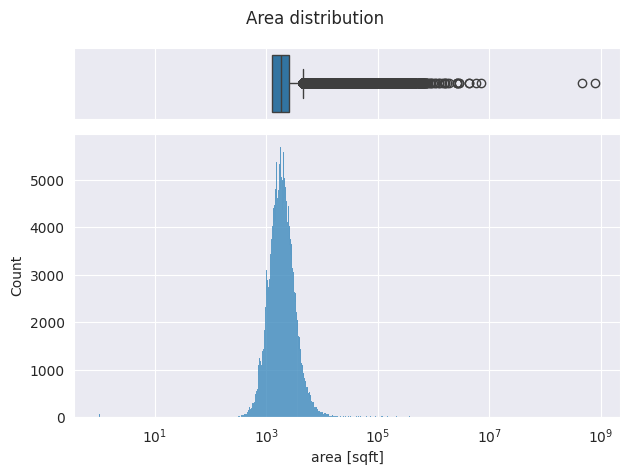

In [11]:
df = build_features.get_df_numerical_sqft(df)
display(df['marked_interior_area'].value_counts())
print(
    'Доля объявлений с явно указанной внутренней жилой площадью:', 
    utils.get_percentage(df['marked_interior_area'].sum(), df.shape[0])
)
print(
    'Доля пропусков площади:', 
    utils.get_percentage(df['sqft'].isna().sum(), df.shape[0])
)

visualize.plot_box_hist_plot(
    df, 
    'sqft', 
    numeric_label='area [sqft]', 
    log_scale=True, 
    title='Area distribution',
);

Видим также большой разброс в площади.
В основном, площадь больше 1000 квадратных футов, или 93 $м^2$

Есть также слишком большие особняки:

In [12]:
df[df['sqft']>1e7]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,marked_interior_area
62736,for sale,NaN,single-family home,1723 Pulte St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1901', 'fac...",yes,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '2/10', '...",795979430.0,45225,2 Beds,OH,1.0,NaN,NaN,1230095,27500,False
376529,Active,NaN,Multi-Family Home,5382 S Dixie Hwy,NaN,"{'atAGlanceFacts': [{'factValue': '2012', 'fac...",NaN,Glendale,"[{'rating': ['5', '7', '7', 'NR', 'NR', 'NR'],...",456602479.0,42740,NaN,KY,NaN,NaN,NaN,10050634,198000,False


При этом цена на них средняя (см выбросы больше $10^7$):

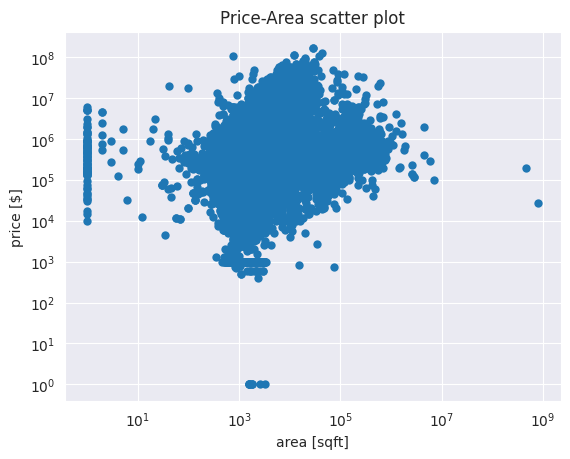

In [13]:
visualize.plot_scatter(
    data=df,
    x='sqft',
    y='target',
    logx=True,
    logy=True,
    x_label='area [sqft]',
    y_label='price [$]',
    title='Price-Area scatter plot',
    linewidth=0,
);

Впоследствии, можно удалить явные выбросы.
Также, возможно имеет смысл логарифмировать площадь.

### stories

Рассмотрим символы и встречающиеся варианты, предварительно переведя всё в lower:

In [14]:
df['stories'] = df['stories'].str.lower()
display(df['stories'].str.findall(r'[^0-9]+').value_counts().head(20))
display_html('<h2>Stories numbers', raw=True)
display(df['stories'].str.findall(r'[0-9]+').value_counts().head(30))
display_html('<h2>Stories contain "ground", "one", "two" or "three"', raw=True)
display(
    df[
        df['stories'].str.contains('ground', na=False) |
        df['stories'].str.contains('one', na=False) |
        df['stories'].str.contains('two', na=False) |
        df['stories'].str.contains('three', na=False)
    ]['stories'].value_counts()
)
display_list = ['split', 'story', 'level', 'lot']
for word in display_list:
    display_html(f'<h2>Stories contain "{word}"', raw=True)
    display(
        df[
            df['stories'].str.contains(word, na=False)
        ]['stories'].value_counts()
    )

display_html(f'<h2>Property type of Stories with zeros', raw=True)
display(
    df[
        df['stories'].isin(['0', '0.0'])
    ]['propertyType'].value_counts()
)

stories
[.]                     154467
[]                       51919
[one]                     5758
[ story]                  3470
[two]                     2495
[+]                        868
[three or more]            569
[one story]                395
[ level, site built]       380
[lot]                      365
[townhouse]                325
[ranch/,  story]           293
[multi/split]              271
[ level]                   268
[two story or more]        253
[ stories]                 243
[acreage]                  215
[.,  story]                203
[condominium]              172
[ story/basement]          161
Name: count, dtype: int64

Stories numbers

stories
[1, 0]       66808
[2, 0]       55003
[1]          24820
[2]          20776
[]           12074
[3, 0]       11233
[0, 0]        7209
[3]           5358
[0]           4231
[9, 0]        2914
[2, 00]       2775
[4, 0]        2136
[1, 00]       1200
[4]            933
[6, 0]         716
[1, 50]        650
[5, 0]         614
[1, 5]         566
[3, 00]        517
[9]            467
[7, 0]         312
[6]            291
[8, 0]         254
[2, 0000]      229
[5]            189
[1, 0000]      116
[2, 5]          97
[12, 0]         94
[2, 50]         92
[7]             92
Name: count, dtype: int64

Stories contain "ground", "one", "two" or "three"

stories
one                                5758
two                                2495
three or more                       569
one story                           395
two story or more                   253
one level                           142
one and one half                     25
three or more levels                 25
one, two                             13
three or more, multi/split            7
ground level                          6
two stories                           4
ground level, one                     3
two, multi/split                      3
one, three or more                    3
multi/split, two                      1
ground level, split level, two        1
ground level, two                     1
one, two, multi/split                 1
two, three or more                    1
other, two, multi/split               1
multi level, three or more            1
one and one half, three or more       1
Name: count, dtype: int64

Stories contain "split"

stories
multi/split                         271
split level                          52
split foyer                          14
site built, split foyer               9
split level w/ sub                    8
three or more, multi/split            7
two, multi/split                      3
site built, split level               3
2 story, split level                  2
3 level, site built, split level      1
ground level, split level, two        1
multi/split, two                      1
2 level, site built, split foyer      1
split foyer, tri-level                1
other, two, multi/split               1
bedroom - split plan                  1
1 story, split level                  1
2 level, split foyer                  1
split entry (bi-level)                1
one, two, multi/split                 1
1 level, split foyer                  1
Name: count, dtype: int64

Stories contain "story"

stories
2 story                                       1970
1 story                                       1253
one story                                      395
ranch/1 story                                  293
two story or more                              253
3 story                                        204
1.5 story                                      169
2 story/basement                               154
1 story basement                                82
4 story                                         43
1 story/ranch                                   40
2.5 story                                       34
1.5 story/basement                              33
1 story/f.r.o.g.                                13
3 story/basement                                 7
3+ story                                         4
multi-story                                      3
2 story, tri level                               2
1 story, 2 story                                 2
2 story, split level   

Stories contain "level"

stories
2 level, site built               192
1 level, site built               155
1 level                           148
one level                         142
stories/levels                    133
                                 ... 
3 story, tri level                  1
multi level, three or more          1
3 story, multi level                1
split entry (bi-level)              1
3 level, site built, tri-level      1
Name: count, Length: 62, dtype: int64

Stories contain "lot"

stories
lot    365
Name: count, dtype: int64

Property type of Stories with zeros

propertyType
Single Family            7639
Condo                    2141
Townhouse                 768
Multi Family              416
Mobile / Manufactured     402
Cooperative                50
Apartment                  19
SingleFamilyResidence       3
Name: count, dtype: int64

- "one", "two", "three" можно заменить на числовые эквиваленты.
- "ground" можно заменить на 1.

Также:
- "split", "tri", "multi" предполагают больше, чем 1 этаж. Можно положить равенство 1.5. Но решение принимается ниже.
- Нулевые значения можно рассматривать как отсутствие этих значений, так как среди `propertyType` отсутствует Land.
Впоследствии, пропуски можно заполнить по `propertyType`.
- "lot" можно рассматривать как ноль этажей - продаётся земельный участок.
- Есть также количества этажей больше 3 (даже 8, 9 и больше). Требуется проверить потом

Будем создавать отдельный признак для последующей проверки

Для начала, заменим на числовые значения. И проанализируем кейсы без чисел вообще

In [15]:
df['stories'] = build_features.replace(
    df['stories'],
    to_replace=(
        ('ground', '1'),
        ('one', '1'),
        ('two', '2'),
        ('three', '3'),
    )
)
# Get stories sorted by count of appearance
no_num_stories = df[
    ~df['stories'].str.contains(r'[0-9]+', na=False)
]['stories'].value_counts().head(9)

# Display propertyTypes for popular no-number stories
for value in no_num_stories.index:
    display_html(f'<h3>{value}', raw=True)
    display(df[df['stories'] == value]['propertyType'].value_counts())

lot

propertyType
Land    365
Name: count, dtype: int64

townhouse

propertyType
Condo/Townhome/Row Home/Co-Op    325
Name: count, dtype: int64

multi/split

propertyType
Split-Level                               110
High Rise, Split-Level                     38
Cluster Home, Split-Level                  11
Garden Home, Split-Level                   10
Condo/Townhome/Row Home/Co-Op              10
Detached, Two Story, Split-Level            9
Detached, One Story, Split-Level            7
Single Family Home                          6
Detached, Split-Level                       6
Two Story, Split-Level                      5
Penthouse, Split-Level                      5
One Story, Split-Level                      4
Traditional                                 3
Multi-Family Home                           3
Bi-Level, Split-Level                       2
Bungalow                                    2
Custom                                      2
Cluster Home, Garden Home, Split-Level      2
Contemporary                                2
Florida                                     2
Colonial, Split-Level                       2
Spanish/Mediterranean

acreage

propertyType
Land    215
Name: count, dtype: int64

condominium

propertyType
Condo/Townhome/Row Home/Co-Op    172
Name: count, dtype: int64

stories/levels

propertyType
Single Family Home               95
Condo/Townhome/Row Home/Co-Op    38
Name: count, dtype: int64

ranch

propertyType
Single Family Home               120
Condo/Townhome/Row Home/Co-Op      7
Name: count, dtype: int64

traditional

propertyType
Single Family Home    88
Name: count, dtype: int64

mid-rise

propertyType
Condo/Townhome/Row Home/Co-Op    78
Name: count, dtype: int64

Примем:
- "lot" и "acreage" можно выставить 0
- "ranch" и "traditional"  - 1 этаж
- "multi/split", "stories/levels" - встречаются разные типы и количества этажей в `propertyType`. 
Сходу сложно определить этаж.
Возможно, стоит установить None, но поставим пока 1.5
- "townhouse" - как правило 2, макс. 3 этажа. Причём для townhouse в дальнейшем можно было ввести уточнение в `propertyType`
- "condominium", "mid-rise" - 3 и более этажей.

Заполним численные значения в соответствии с рекомендациями выше:

count    213162.000000
mean          2.011041
std           4.341044
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1120.000000
Name: stories, dtype: float64

Доля объявлений с пропуском численного количества этажей: 43.051%


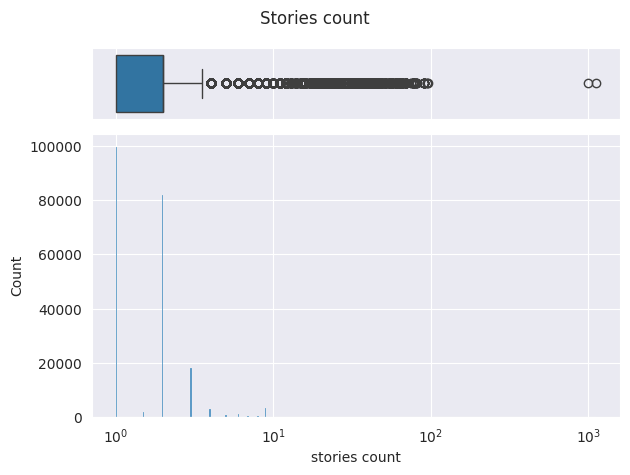

In [16]:
df = build_features.get_df_numerical_story(df)
display(df['stories'].describe())
print(
    'Доля объявлений с пропуском численного количества этажей:', 
    utils.get_percentage(df['stories'].isna().sum(), df.shape[0])
)

visualize.plot_box_hist_plot(
    df, 
    'stories', 
    numeric_label='stories count', 
    log_scale=True, 
    title='Stories count',
);

Несмотря на попытки заполнить это количество этажей, по-прежнему много пропусков.
Возможно, впоследствии удастся их заполнить, проанализировав `propertyType`

Есть выбросы, с которыми также необходимо будет разобраться!

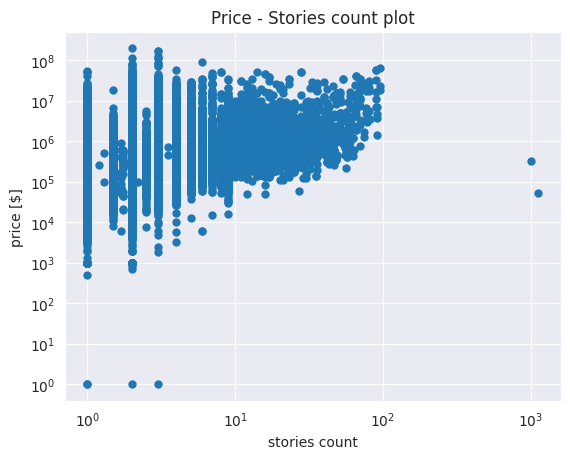

In [17]:
visualize.plot_scatter(
    data=df,
    x='stories',
    y='target',
    logx=True,
    logy=True,
    x_label='stories count',
    y_label='price [$]',
    title='Price - Stories count plot',
    linewidth=0,
);

По нижней границе стоимости видим тенденцию к возрастанию

## baths и beds

Рассмотрим, как выглядят значения в категориях baths и beds

In [18]:
display(df['baths'].value_counts().head(50))
display(df['beds'].value_counts().head(50))

baths
2 Baths         51953
3 Baths         35356
2               20429
2.0             16355
4 Baths         14712
3.0             10797
3               10093
Bathrooms: 2     9411
2.5              8113
Bathrooms: 3     6569
1                6569
1.0              5799
5 Baths          5365
4.0              4559
2.5 Baths        4388
0                3811
4                3561
3.5              3455
Bathrooms: 1     3126
2 ba             2679
6 Baths          2599
Bathrooms: 4     2372
1,500            2207
3 ba             1884
1.5              1857
2,000            1792
3.5 Baths        1789
1,750            1720
3,000            1684
5.0              1551
2,250            1440
1,000            1279
5                1219
7 Baths          1208
1,250            1203
4.5              1016
2,750             964
2,500             894
Bathrooms: 5      823
~                 780
1 ba              747
4 ba              735
6.0               733
3,500             653
8 Baths           638
6   

beds
3 Beds        52947
4 Beds        35149
3             31191
2 Beds        26084
4             19915
2             15998
Baths         15258
3 bd          12678
5 Beds        11205
4 bd           8193
3.0            8085
5              6392
4.0            5231
2 bd           5166
1              4583
6 Beds         3784
5 bd           2619
2.0            2429
6              1792
5.0            1372
0              1208
7 Beds         1095
1 bd           1068
-- bd           845
8 Beds          754
Bath            737
6 bd            643
7               510
1.0             429
                350
9 Beds          345
8               316
6.0             311
0.0             223
10 Beds         175
7 bd            145
12 Beds         130
8 bd             94
9                94
-- sqft          94
5,000 sqft       90
11 Beds          84
7.0              67
10               66
1 acre           46
64 Beds          44
16 Beds          41
8.0              41
0.34 acres       39
0.28 acres     

Baths:
- Нередко, есть приписки типа "Baths", "Bathrooms"
- Есть пропуски, обозначенные "~" или "--"
- Также есть странные значения, типа "1,500", "1,750", "2,000" и так далее. 
Наличие нулевых значений после запятой не даёт возможности полагать, что это некая "суммарная площадь", если только это не обозначение пропуска в данных. 
Также, нереально предполагать, что это тысячи ванных комнат (нередко тип дома - частный жилой).

Посмотрим, что при этом указано в beds:

In [19]:
df[df['baths'].str.contains(',', na=False)]['beds'].value_counts()

beds
Baths    14056
Bath       209
             1
Name: count, dtype: int64

Видим, что при наличии запятой в выражении, идёт ссылка на "Bath", а также есть один пропуск.
Можем предположить, что речь идёт о паре "спальня с ванной".

Пожалуй, имеет смысл полагать дробное разделение

In [20]:
df[df['baths'].str.contains(',', na=False)][['propertyType', 'baths', 'beds', 'sqft', 'stories']].head(40)

,propertyType,baths,beds,sqft,stories
16,NaN,"1,750",Baths,2203.0,NaN
22,"Penthouse, Split-Level","1,000",Baths,1080.0,1.5
26,NaN,"1,000",Baths,NaN,NaN
115,"1 Story, Ranch","2,500",Baths,1470.0,NaN
182,"1 Story, Traditional","4,000",Baths,3097.0,NaN
207,NaN,"2,000",Baths,NaN,NaN
210,NaN,"3,000",Baths,3671.0,NaN
328,NaN,"2,000",Baths,2050.0,NaN
332,NaN,"1,500",Baths,1544.0,NaN
341,"Contemporary/Modern, Traditional","1,250",Baths,3004.0,3.0


Сопоставим площади, когда есть acres в Beds:

In [21]:
print('when acre in beds')
display(
    raw_df[
        raw_df['beds'].str.contains('acre', na=False)
    ]['sqft'].value_counts(dropna=False)
)

print('when sqft in beds')
display(
    raw_df[
        raw_df['beds'].str.contains('sqft', na=False)
    ]['sqft'].value_counts(dropna=False)
)

when acre in beds


sqft
NaN           1628
-- sqft         11
1,844 sqft       1
Name: count, dtype: int64

when sqft in beds


sqft
NaN           1413
-- sqft         16
1,076 sqft       1
1,400 sqft       1
1,752 sqft       1
1,600 sqft       1
1 sqft           1
1,652 sqft       1
Name: count, dtype: int64

Видим, что в большинстве случаев данные по площади попросту отсутствуют, поэтому положим значение None для значения acres и sqft.
При необходимости, можно было бы заполнить пропуски в "sqft" из Beds.
Однако, доля очень мала, и особо не изменит ситуации по пропускам в площади.

### Последовательность обработки признаков baths и beds:

Baths:
- Заполнить None-ами строки, содержащие "--", "~", пустые строки после удаления лишних пробелов
- Заменить запятые на точки
- Извлечь числовые значения (в общем случае, с плавающей точкой), а при отсутствии таковых - None

Beds:
- Заполнить None-ами строки, содержащие "--", "~", пустые строки после удаления лишних пробелов
- Заполнить None-ами строки, содержащие "acre", "sqft"
- Заполнить значениями из Baths, если идёт ссылка на них
- Извлечь числовые значения (в общем случае, с плавающей точкой), а при отсутствии таковых - None

baths


count    267467.000000
mean          3.384831
std          22.286381
min           0.000000
25%           2.000000
50%           2.500000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

Доля объявлений с пропуском в baths: 28.543%
beds


count    277504.000000
mean          3.901398
std          21.223677
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         750.000000
Name: beds, dtype: float64

Доля объявлений с пропуском в beds: 25.862%


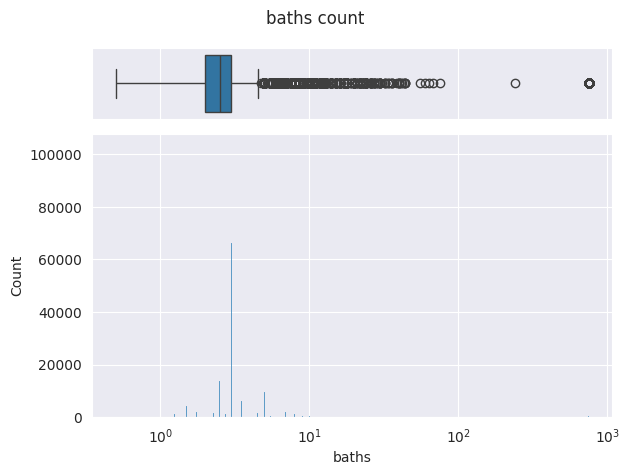

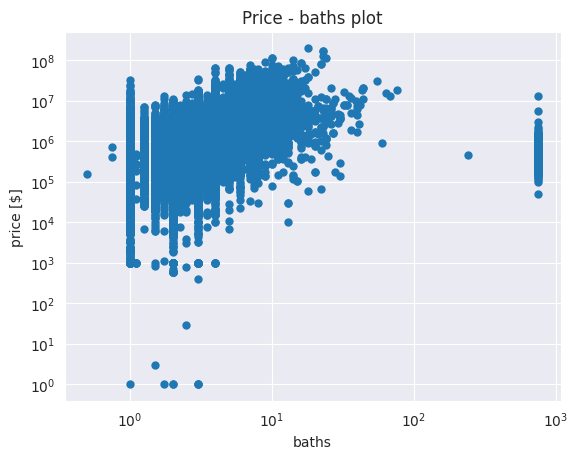

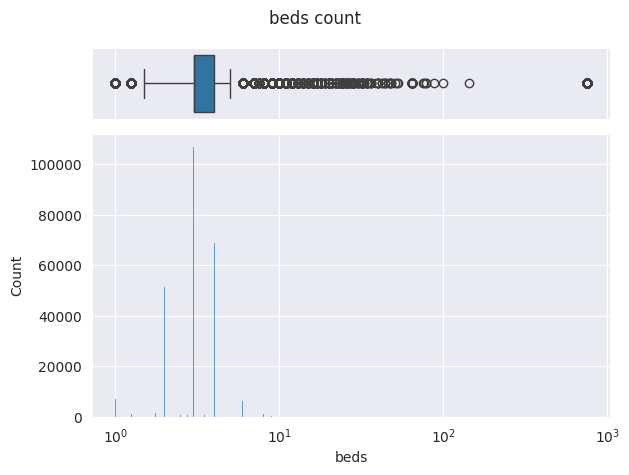

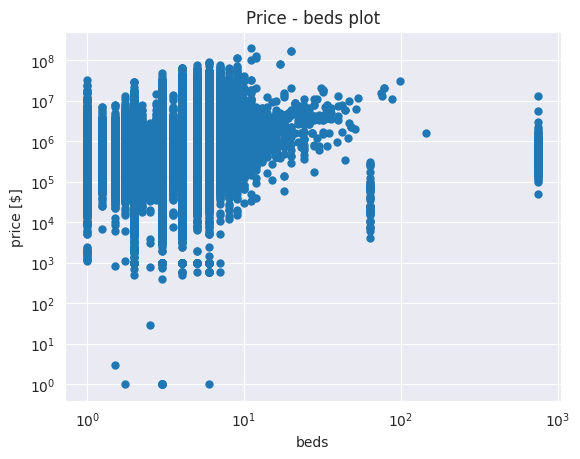

In [22]:
df['baths'] = build_features.get_numerical_feature(
    df['baths'],
    to_none=('--', '~', ''),
    to_replace=((',', '.'),)
)
df = build_features.get_df_beds_from_baths(df)

df['beds'] = build_features.get_numerical_feature(
    df['beds'],
    to_none=('--', '~', '', 'sqft', 'acre'),
)

for feature_name in ['baths', 'beds']:
    print(feature_name)
    display(df[feature_name].describe())
    print(
        f'Доля объявлений с пропуском в {feature_name}:', 
        utils.get_percentage(df[feature_name].isna().sum(), df.shape[0])
    )

    visualize.plot_box_hist_plot(
        df, 
        feature_name, 
        log_scale=True, 
        title=f'{feature_name} count',
    );
    
    visualize.plot_scatter(
        data=df,
        x=feature_name,
        y='target',
        logx=True,
        logy=True,
        y_label='price [$]',
        title=f'Price - {feature_name} plot',
        linewidth=0,
    );

Имеются как пропуски, так и выбросы. Потребуется последующая обработка.

В целом, имеется тенденция к увеличению стоимости жилья при увеличении числа ванных и спальных комнат!

## private pool и PrivatePool

In [23]:
display(df['private pool'].value_counts(dropna=False))
display(df['PrivatePool'].value_counts(dropna=False))

private pool
NaN    370155
Yes      4151
Name: count, dtype: int64

PrivatePool
NaN    334280
yes     28592
Yes     11434
Name: count, dtype: int64

Так как есть либо значение, либо None, то там где есть значения, оставляем "yes", в остальных "no"

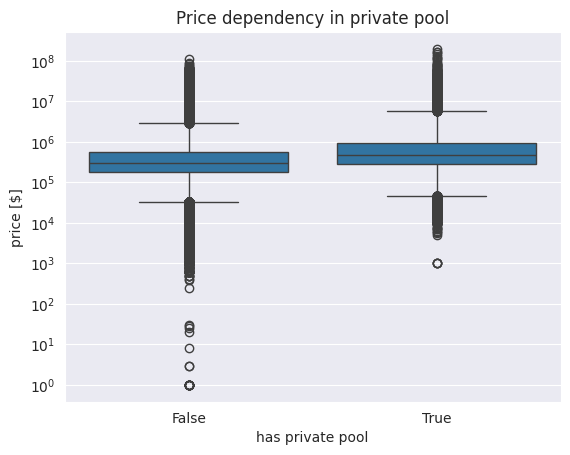

In [24]:
# fill with True if mark exists
df = build_features.get_df_private_pool(df)

visualize.plot_boxplot(
    df,
    numeric_feature='target',
    categorical_feature='private_pool',
    orient='v',
    log_scale=True,
    numeric_label='price [$]',
    categorical_label='has private pool',
    title='Price dependency in private pool'
);

После удаления выбросов можно будет проверить статистическую значимость расхождения в стоимости.
Но по графику мы наблюдаем повышение стоимости недвижимости при наличии бассейна, что логично.

## mls-id и MlsId

In [25]:
display(df['mls-id'].value_counts(dropna=False))
display(df['MlsId'].value_counts(dropna=False))

mls-id
NaN          349369
No MLS#           3
No                3
39888954          2
201909981         2
              ...  
A10762436         1
1592770           1
14201834          1
816230            1
F10202858         1
Name: count, Length: 24903, dtype: int64

MlsId
NaN                        64337
NO MLS                        24
No MLS #                      16
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
                           ...  
241208                         1
687215                         1
3866902                        1
19491906                       1
10374233                       1
Name: count, Length: 232623, dtype: int64

Имеет смысл создать один признак `mls`, отвечающий за участие объявления в Multiple Listing Service - когда к продвижению объявления подключаются и другие агенства.

Важно отметить, что присутствуют скрытые пропуски, типа "No" и "No MLS", лучше начать с их обработки - переводим в None.

Затем, по аналогии с private pool создаём бинарный признак: True, если есть сведения, False - если нет

Но прежде, чем выбрать паттерн заполнения неявных пропусков, посмотрим на данные, содержащие No:

In [26]:
for mls_column in ['mls-id', 'MlsId']:
    display(
        df[
            df[mls_column].str.lower().str.strip().str.contains('no', na=False)
        ][mls_column].value_counts()
    )

mls-id
No         3
No MLS#    3
No mls     1
NO MLS     1
Name: count, dtype: int64

MlsId
NO MLS                                 24
No MLS #                               16
No                                      9
No mls                                  8
NOMLSID                                 6
                                       ..
 C, Reno, NV 89502                      1
 B411, North Miami, FL 33161            1
 2509, North Miami, FL 33181            1
 E1004, North Miami Beach, FL 33162     1
 301, North Bay Village, FL 33141       1
Name: count, Length: 95, dtype: int64

В случае с "mls-id" всё просто, достаточно сделать None-ами значения, содержащие "no".
Однако, в случае с "MlsId" мы рискуем заполнить таким образом None-ами значения, содержащие "no" в строке адреса.
Как правило, в случае с адресом, есть запятые проверим догадку:

In [27]:
for mls_column in ['mls-id', 'MlsId']:
    display(
        df[
            df[mls_column].str.lower().str.strip().str.contains('no', na=False)
            &
            ~df[mls_column].str.lower().str.strip().str.contains(',', na=False)
        ][mls_column].value_counts()
    )

mls-id
No         3
No MLS#    3
No mls     1
NO MLS     1
Name: count, dtype: int64

MlsId
NO MLS        24
No MLS #      16
No             9
No mls         8
No MLS         6
NOMLSID        6
NON1614        2
No MLS         2
NON MLS        1
NonMLS         1
non MLS        1
NOT ON MLS     1
No  MLs #      1
462NON         1
Name: count, dtype: int64

Воспользуемся такой маской.

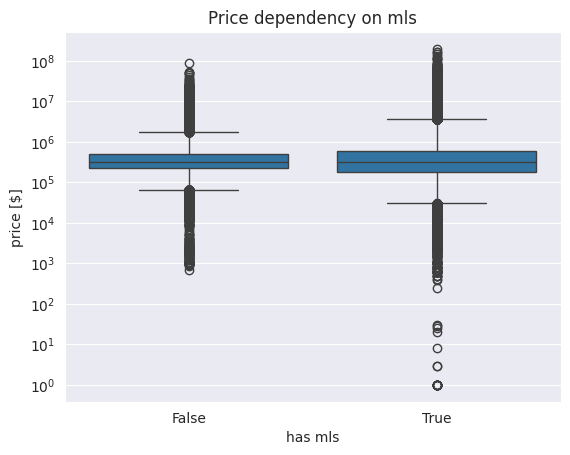

In [28]:
df = build_features.get_df_mls(df)
visualize.plot_boxplot(
    df,
    numeric_feature='target',
    categorical_feature='mls',
    orient='v',
    log_scale=True,
    numeric_label='price [$]',
    categorical_label='has mls',
    title='Price dependency on mls'
);

По boxplot статистически значимая разница в цене не обнаружена.

Возможно, имеет смысл удалить этот признак впоследствии

## fireplace

Посмотрим на встречающиеся значения.
Выведем топ 20 первых и последних (уникальных значений)

In [29]:
display(df['fireplace'].value_counts().head(20))
display(df['fireplace'].value_counts().tail(20))

fireplace
yes                   49925
Yes                   20619
1                     14533
2                      2432
Not Applicable         1990
Fireplace               847
3                       563
Living Room             433
LOCATION                399
Wood Burning            311
Gas/Gas Logs            300
No                      289
Fireplace YN            287
Special Features        279
1 Fireplace             274
0                       270
FAMILYRM                246
Fireplace Features      239
Great Room              207
Wood                    206
Name: count, dtype: int64

fireplace
Den, FAMILYRM, Great Room                                                                          1
Central Vacuum, Elevator, Walk-In Closets, Wet Bar                                                 1
Den, Kitchen                                                                                       1
Three, Gas Log                                                                                     1
FAMILYRM, Great Room, Living Room                                                                  1
In Den, Gas Logs, In Living Room                                                                   1
2 Fireplaces, Decorative Fireplace, Family Room, Gas Burning, Master Bedroom                       1
Brick, Flue, Wood Burning Stove                                                                    1
SMCAM                                                                                              1
1 Fireplace, Family Room, Gas Starter                                            

Так как в ряде случаев встречается подробное описание по наличию, месторасположению и типу камина, то проще присвоить тип "нет камина" для None и других признаков отсутствия, а для остальных - есть.

Доля объявлений с камином и без:


fireplace
False    0.733192
True     0.266808
Name: proportion, dtype: float64

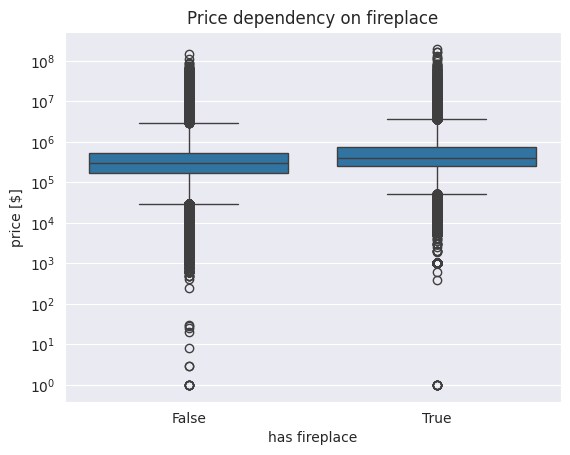

In [30]:
no_fireplace_labels = ('not applicable', 'no', 'no fireplace', '0')
df['fireplace'] = build_features.get_bool_feature(
    df['fireplace'], no_fireplace_labels
)
print('Доля объявлений с камином и без:')
display(df['fireplace'].value_counts(normalize=True))
visualize.plot_boxplot(
    df,
    numeric_feature='target',
    categorical_feature='fireplace',
    orient='v',
    log_scale=True,
    numeric_label='price [$]',
    categorical_label='has fireplace',
    title='Price dependency on fireplace'
);

Только 27% объявлений с камином.

При этом по медиане стоимость домов с камином выше, что логично.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                335049 non-null  object 
 1   propertyType          339752 non-null  object 
 2   street                374304 non-null  object 
 3   baths                 267467 non-null  float64
 4   homeFacts             374306 non-null  object 
 5   fireplace             374306 non-null  bool   
 6   city                  374272 non-null  object 
 7   schools               374306 non-null  object 
 8   sqft                  333384 non-null  float64
 9   zipcode               374306 non-null  object 
 10  beds                  277504 non-null  float64
 11  state                 374306 non-null  object 
 12  stories               213162 non-null  float64
 13  target                374306 non-null  int64  
 14  marked_interior_area  374306 non-null  bool   
 15  priva

TODO:
- propertyType
- street, city, state, zipcode (если можно что извлечь)
- homeFacts и schools

## status

Оценим, какие типы есть в status

In [32]:
status = df['status'].str.strip().str.lower()
display(status.value_counts().head(30))
display(status.value_counts().tail(20))

status
for sale                             199567
active                               105206
foreclosure                            6020
new construction                       5459
pending                                4802
pre-foreclosure                        2000
p                                      1488
pre-foreclosure / auction              1281
under contract show                    1183
/ auction                               799
under contract   showing                793
active under contract                   718
under contract                          692
new                                     690
contingent                              581
price change                            563
auction                                 493
a active                                443
foreclosed                              294
under contract backups                  252
contingent finance and inspection       245
pending continue to show                194
back on market           

status
coming soon: dec 27.         1
temporary active             1
coming soon: nov 17.         1
coming soon: oct 24.         1
coming soon: oct 21.         1
pending w/escape clause      1
coming soon: nov 26.         1
coming soon: nov 14.         1
contract                     1
pending, continue to show    1
contingent   no show         1
pending bring backup         1
conditional contract         1
coming soon: nov 8.          1
coming soon: oct 29.         1
coming soon: dec 15.         1
coming soon: dec 25.         1
pending backups wanted       1
coming soon: nov 23.         1
coming soon: dec 23.         1
Name: count, dtype: int64

Рассмотрим статистику по ключевым статусам:

Для продажи:

In [33]:
status[status.str.contains('for sale', na=False)].value_counts()

status
for sale    199567
Name: count, dtype: int64

In [34]:
status[status.str.contains('sale', na=False)].value_counts()

status
for sale                             199567
p pending sale                           35
contract contingent on buyer sale        25
pending sale                              2
contingent - sale of home                 1
Name: count, dtype: int64

Активная сделка (есть и другие слова вместе с ключевым):

In [35]:
status[status.str.contains('active', na=False)].value_counts()

status
active                       105206
active under contract           718
a active                        443
active with offer                49
active backup                    39
auction - active                 28
active/contingent                15
active with contingencies        13
active - auction                 10
active contingency                8
active option                     7
active option contract            7
active contingent                 6
active - contingent               2
active with contract              2
temporary active                  1
Name: count, dtype: int64

Новая сделка:

In [36]:
status[status.str.contains('new', na=False)].value_counts()

status
new construction    5459
new                  690
Name: count, dtype: int64

Приближается время начала (малочисленная группа):

In [37]:
status[status.str.contains('coming', na=False)].value_counts()

status
coming soon: nov 29.    10
coming soon: dec 6.      8
coming soon: dec 5.      7
coming soon: dec 4.      6
coming soon: nov 27.     5
coming soon: dec 13.     5
coming soon: dec 7.      4
coming soon: dec 3.      4
coming soon: nov 19.     4
coming soon: nov 28.     4
coming soon: dec 10.     4
coming soon: nov 30.     4
coming soon: dec 9.      3
coming soon: dec 14.     3
coming soon: dec 2.      3
coming soon: nov 13.     2
coming soon: dec 20.     2
coming soon: dec 11.     2
coming soon: oct 30.     2
coming soon: nov 21.     2
coming soon: nov 22.     2
coming soon: dec 16.     2
coming soon: dec 18.     2
coming soon: dec 24.     2
coming soon: nov 17.     1
coming soon: nov 25.     1
coming soon: dec 1.      1
coming soon: nov 12.     1
coming soon: nov 5.      1
coming soon: dec 12.     1
coming soon: nov 23.     1
coming soon: nov 14.     1
coming soon: dec 15.     1
coming soon: nov 11.     1
coming soon: oct 29.     1
coming soon: nov 8.      1
coming soon: oct 21. 

Лишён права выкупа:

In [38]:
status[
    status.str.contains('foreclos', na=False) & 
    ~status.str.contains('pre', na=False)
].value_counts()

status
foreclosure                 6020
foreclosed                   294
contingent   foreclosure       2
Name: count, dtype: int64

Аукцион до выкупа:

In [39]:
status[
    status.str.contains('foreclos', na=False) &
    status.str.contains('pre', na=False)
].value_counts()

status
pre-foreclosure              2000
pre-foreclosure / auction    1281
Name: count, dtype: int64

Under contract, no backup

In [40]:
status[
    status.str.contains('under contract', na=False) &
    ~status.str.contains('backup', na=False)
].value_counts()

status
under contract show                     1183
under contract   showing                 793
active under contract                    718
under contract                           692
u under contract                          10
under contract - show                      9
under contract - no show                   2
under contract w/ bckp                     1
under contract taking back up offers       1
Name: count, dtype: int64

Backup

In [41]:
status[status.str.contains('backup', na=False)].value_counts()

status
under contract backups              252
pending taking backups               63
active backup                        39
pending - taking backups             17
contingent take backup               14
backup contract                       6
accepting backups                     2
pending - backup offer requested      2
pending bring backup                  1
pending w/backup wanted               1
pending backups wanted                1
pending take backups                  1
conting accpt backups                 1
backup                                1
Name: count, dtype: int64

Contingency, Contingent.

In [42]:
status[status.str.contains('contingen', na=False)].value_counts()

status
contingent                           581
contingent finance and inspection    245
contingent show                      101
pending with contingencies            44
contract contingent on buyer sale     25
active/contingent                     15
contingent take backup                14
active with contingencies             13
contingent   show                     13
ct insp - inspection contingency      10
contingent escape                     10
contingency contract                   9
active contingency                     8
active contingent                      6
contingent lien holder release         5
contingency 48 hr (+/ )                5
contingent   release                   3
active - contingent                    2
contingent   foreclosure               2
contingent - financing                 2
contingent   no show                   1
contingent - sale of home              1
Name: count, dtype: int64

Pending. Требуется разделение

In [43]:
status[status.str.contains('pending', na=False)].value_counts()

status
pending                                   4802
pending continue to show                   194
option pending                             110
pending taking backups                      63
pending with contingencies                  44
p pending sale                              35
pending - taking backups                    17
offer pending signature                     15
pending inspection                          14
pending in                                  13
pending w/insp finance                      10
pending ab                                   7
pending   continue to show   financing       5
pending offer approval                       4
lease/purchase pending                       3
pending   continue to show                   3
pending fe                                   3
pending (do not show)                        2
pending w/ cont.                             2
pending - continue to show                   2
pending sale                                 2
pendin

In [44]:
status[
    status.str.contains('diligence', na=False)
].value_counts()

status
due diligence period    27
Name: count, dtype: int64

In [45]:
status[status.str.contains('activ', na=False)].value_counts()

status
active                       105206
active under contract           718
a active                        443
active with offer                49
active backup                    39
auction - active                 28
active/contingent                15
active with contingencies        13
active - auction                 10
active contingency                8
active option contract            7
active option                     7
active contingent                 6
active - contingent               2
active with contract              2
re activated                      2
temporary active                  1
reactivated                       1
Name: count, dtype: int64

In [46]:
status[status.str.contains('auction', na=False)].value_counts()

status
pre-foreclosure / auction    1281
/ auction                     799
auction                       493
auction - active               28
active - auction               10
Name: count, dtype: int64

На текущий момент, имеет смысл группировать только те категории, которые явно схожи!
Однако, на следующем этапе EDA потребуется сгруппировать вместе ряд категорий, так как многие из них малочисленные

Количество "None" увеличилось на 2.881%


status
sale               199567
active             105649
NaN                 40388
pending              6717
foreclosure          6314
new                  6149
under_contract       3409
pre-foreclosure      3281
auction              1330
contingency          1115
backup                387
Name: count, dtype: int64

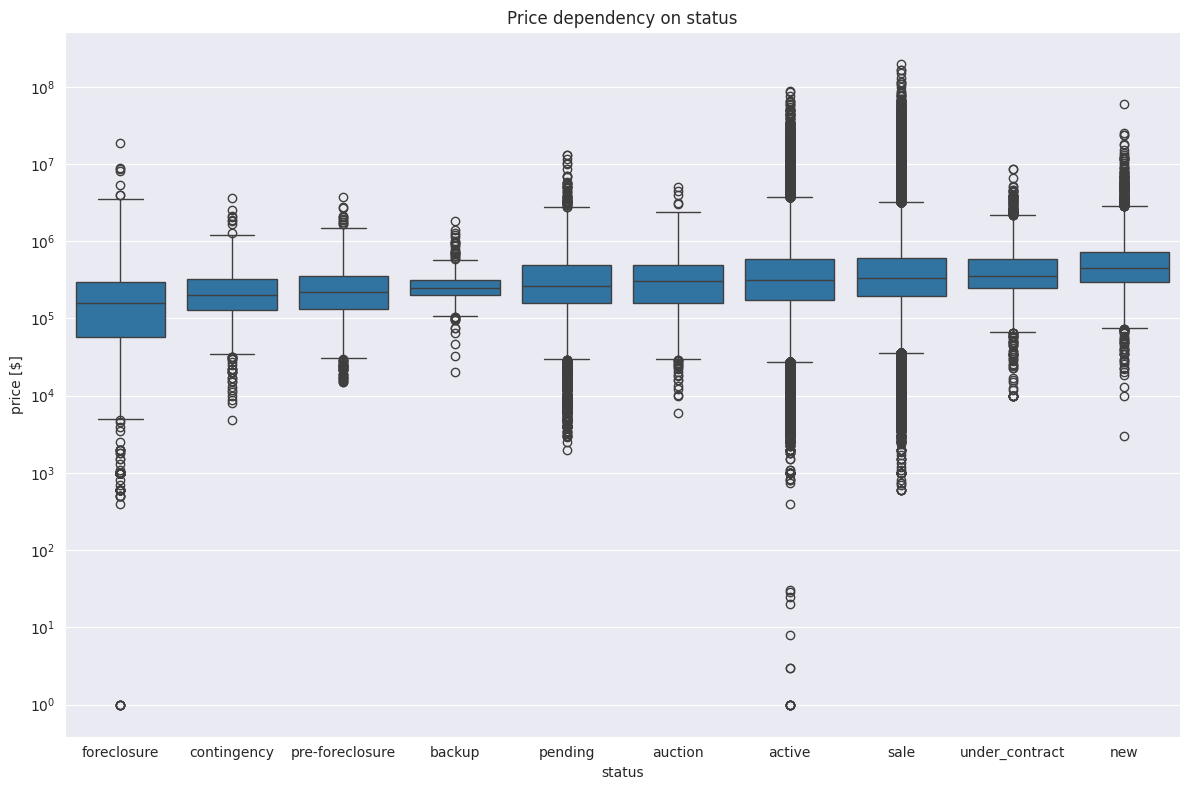

In [47]:
new_status = build_features.get_status_feature(df['status'])
new_none_percentage = utils.get_percentage(
    new_status.isna().sum() - status.isna().sum(),
    status.isna().sum()
)
print(f'Количество "None" увеличилось на {new_none_percentage}')
display(new_status.value_counts(dropna=False))

df['status'] = new_status

visualize.plot_boxplot(
    df,
    numeric_feature='target',
    categorical_feature='status',
    orient='v',
    log_scale=True,
    numeric_label='price [$]',
    title='Price dependency on status',
    figsize=(12,8),
    ordered=True
);
plt.tight_layout()

- Видим, что наиболее высокая цена у домов со статусом "new", а самая низкая у "foreclosure".

- "backup" и "pending" близки друг к другу.

- Между "active" и "sale" слабая разница в цене.

После удаления выбросов потребуется более детальный анализ с выделением более крупных категорий.

## propertyType

In [48]:
property_type = df['propertyType'].str.lower().str.strip()
display(property_type.value_counts(dropna=False).head(30))
display(property_type.value_counts(dropna=False).tail(20))

propertyType
single-family home               91159
single family                    61888
condo                            42372
NaN                              34554
single family home               31725
lot/land                         20532
townhouse                        18305
land                             10933
multi-family                      7763
condo/townhome/row home/co-op     7701
traditional                       5912
coop                              3265
multi family                      2772
high rise                         1823
ranch                             1781
detached, one story               1614
mobile/manufactured               1613
single detached, traditional      1581
contemporary                      1556
multi-family home                 1501
1 story                           1235
colonial                          1204
mobile / manufactured             1056
contemporary/modern               1000
2 stories                          911
apartment   

propertyType
traditional, art deco, beaux arts                                         1
farm/ranch house, single detached, contemporary/modern, ranch             1
a-frame, victorian/federal                                                1
contemporary, modernist, ranch, rustic                                    1
30x40 building                                                            1
split-entry, craftsman                                                    1
custom, florida, other, spanish/mediterranean                             1
single detached, contemporary/modern, ranch, traditional                  1
colonial, english, traditional                                            1
single detached, contemporary/modern, other (see remarks), traditional    1
1 story, spanish, ranch, traditional                                      1
condo/townhome, single detached                                           1
contemporary/modern, french, mediterranean, traditional                   1

Сформируем список уникальных свойств и посмотрим на их популярность

In [49]:
from collections import Counter

all_types = []
def append_types(lt:list, all_types:list=all_types):
    lt = map(lambda x: x.strip(), lt)
    all_types.extend(lt)
    return lt

property_type[property_type.notna()].str.split(',').apply(append_types)
Counter(all_types)

Counter({'single-family home': 91159,
         'single family': 61888,
         'condo': 42373,
         'single family home': 31725,
         'lot/land': 20532,
         'townhouse': 18484,
         'land': 10933,
         'traditional': 9677,
         'multi-family': 7765,
         'condo/townhome/row home/co-op': 7701,
         'coop': 3265,
         'single detached': 3151,
         'multi family': 2772,
         'ranch': 2711,
         'detached': 2671,
         'one story': 2527,
         'contemporary': 2328,
         'high rise': 1980,
         'contemporary/modern': 1941,
         '1 story': 1811,
         'mobile/manufactured': 1613,
         'multi-family home': 1501,
         '2 stories': 1490,
         'colonial': 1398,
         'two story': 1096,
         'mobile / manufactured': 1056,
         'condo/townhome': 819,
         'apartment': 799,
         'mfd/mobile home': 791,
         'transitional': 780,
         'florida': 767,
         'bungalow': 619,
         'cooper

В целом, топ признаки выше покрыты

По аналогии со "status", проверим вхождения признаков.

Рассмотрим по отдельности "тип дома" и "стиль дома"

### Types

In [50]:
property_type[
    (
        property_type.isin(['lot/land', 'land'])
    )
].value_counts().head(20)

propertyType
lot/land    20532
land        10933
Name: count, dtype: int64

Single family, detached home

In [51]:
property_type[
    (
        property_type.str.contains('single', na=False) |
        property_type.str.contains('detached', na=False)
    ) &
    ~property_type.str.contains('condominium', na=False)
].value_counts().head(20)

propertyType
single-family home                                   91159
single family                                        61888
single family home                                   31725
detached, one story                                   1614
single detached, traditional                          1581
single detached                                        751
detached, two story                                    638
singlefamilyresidence                                  179
single detached, contemporary/modern                   176
single detached, ranch                                  91
detached, ranch, one story                              81
detached                                                81
detached, two story, spanish/mediterranean              67
single detached, craftsman                              59
detached, one story, spanish/mediterranean              53
single detached, other (see remarks)                    48
single detached, ranch, traditional        

In [52]:
property_type[
    property_type.str.contains('ranch', na=False) |
    property_type.str.contains('bungalow', na=False) |
    property_type.str.contains('cabin', na=False) |
    property_type.str.contains(r'ca2\S*n', na=False) |
    property_type.str.contains(r'cottage', na=False) |
    property_type.str.contains(r'farm', na=False)
].value_counts().head(30)

propertyType
ranch                                                      1781
bungalow                                                    442
farms/ranches                                               371
ranch, traditional                                          133
single detached, ranch                                       91
ranch, one story                                             86
detached, ranch, one story                                   81
bungalow, cape cod                                           66
cottage                                                      62
1 story, ranch                                               46
florida, ranch                                               46
single detached, ranch, traditional                          41
rancher                                                      41
farmhouse                                                    40
detached, ranch                                              31
high rise, ranch           

In [53]:
property_type[
    property_type.str.contains('split', na=False) |
    property_type.str.contains('multi-level', na=False)
].value_counts().head(30)

propertyType
split-level                                      110
split level                                       60
high rise, split-level                            38
split level, traditional                          21
multi-level, modern                               16
split-entry                                       15
multi-level                                       15
contemporary/modern, split level                  11
cluster home, split-level                         11
garden home, split-level                          10
detached, two story, split-level                   9
detached, split-level                              8
split                                              8
detached, one story, split-level                   7
split (3 level)                                    7
two story, split-level                             5
split foyer                                        5
contemporary/modern, split level, traditional      5
split (5+ level)                 

Mobile home - that has been manufactured and then transported to the place

In [54]:
property_type[
    property_type.str.contains('manufactured', na=False) |
    property_type.str.contains('mobile', na=False) |
    property_type.str.contains(r'mo2\S*le', regex=True, na=False) |
    property_type.str.contains('prefab', na=False) |
    property_type.str.contains('modular', na=False)
].value_counts().head(20)

propertyType
mobile/manufactured                                        1613
mobile / manufactured                                      1056
mfd/mobile home                                             791
manufactured house, ranch, one story                         16
manufactured house, manufactured home                        14
manufactured house, ranch, one story, manufactured home      13
detached, manufactured home, one story                        9
detached, manufactured home                                   6
manufactured home, mobile home, ranch                         6
manufactured single-wide                                      5
manufactured house, traditional, manufactured home            5
manufactured home, one story                                  4
manufactured home                                             3
single-wide mobile with land                                  2
manufactured double-wide                                      2
modular/prefab, manufacture

In [55]:
property_type[
    property_type.str.contains('apart', na=False)
].value_counts().head(20)

propertyType
apartment                                                                                                                            796
garden apartment                                                                                                                      18
apartment building, farmhouse, other                                                                                                   1
apartment, condo/townhome                                                                                                              1
apartment, attached or 1/2 duplex, condo/townhome, hi-rise, resort property, single detached, vacation home, english, split level      1
apartment, condo/townhome, garden/zero lot line                                                                                        1
Name: count, dtype: int64

In [56]:
property_type[
    property_type.str.contains(r'co-*op', regex=True, na=False)
].value_counts().head(20)

propertyType
condo/townhome/row home/co-op    7701
coop                             3265
cooperative                       533
co-op                              37
co-op, contemporary                 2
co-op, traditional                  1
Name: count, dtype: int64

In [57]:
property_type[
    property_type.str.contains('condo', na=False)
].value_counts().head(20)

propertyType
condo                                               42372
condo/townhome/row home/co-op                        7701
condo/townhome, traditional                           225
condo/townhome                                        183
condo/townhome, contemporary/modern                   180
condominium (single level), contemporary              101
condominium (single level)                             99
condo/unit                                             70
condominium                                            56
condominium (single level), modern                     24
condo/townhome, contemporary/modern, traditional       22
condo/townhome, hi-rise, contemporary/modern           22
condo/townhome, hi-rise, traditional                   21
condominium (single level), traditional                18
condo/townhome, other (see remarks)                    18
condo/townhome, hi-rise                                12
condominium (2 levels)                                 11
c

In [58]:
property_type[
    property_type.str.contains('town', na=False) |
    property_type.str.contains(r'low[-\s]*rise', na=False) |
    property_type.str.contains(r'mid[-\s]*rise', na=False)
].value_counts().head(20)

propertyType
townhouse                                           18305
condo/townhome/row home/co-op                        7701
condo/townhome, traditional                           225
condo/townhome                                        183
condo/townhome, contemporary/modern                   180
low-rise (1-3 stories)                                 90
townhouse, modern                                      80
mid-rise                                               27
condo/townhome, contemporary/modern, traditional       22
condo/townhome, hi-rise, contemporary/modern           22
condo/townhome, hi-rise, traditional                   21
townhouse, contemporary                                20
condo/townhome, other (see remarks)                    18
mid-rise (4-7 stories)                                 15
condo/townhome, hi-rise                                12
townhome style                                         12
condo/townhome, mediterranean                          10
t

In [59]:
property_type[
    property_type.str.contains(r'high[-\s]*rise', na=False)
].value_counts().head(20)

propertyType
high rise                                1823
high rise, penthouse                       51
high-rise (8+ stories)                     38
high rise, split-level                     38
high rise, ranch                           19
garden home, high rise                     13
high-rise                                  12
high rise, multiplex, ranch                 7
high rise, spanish/mediterranean            6
contemporary/modern, high rise              5
high rise, multiplex                        5
cluster home, high rise                     4
contemporary, high rise                     3
high rise, penthouse, tri-level             2
high rise, penthouse, split-level           1
contemporary/modern, high rise, ranch       1
colonial, high rise, ranch                  1
bi-level, high rise                         1
Name: count, dtype: int64

In [60]:
property_type[
    property_type.str.contains(r'multi[-\s]+family', regex=True, na=False)
].value_counts()

propertyType
multi-family                      7763
multi family                      2772
multi-family home                 1501
farmhouse, multi-family              1
historic vintage, multi-family       1
Name: count, dtype: int64

In [61]:
print('Количество заявок, содержащих инфо про story/level в propertyType но с незаполненными stories')
print(
    df[
        (
            property_type.str.contains('stor', na=False) |
            property_type.str.contains('level', na=False)
        )&
        df['stories'].isna()
    ].shape[0]
)

display(
property_type[
    property_type.str.contains('stor', na=False) |
    property_type.str.contains('level', na=False)
].value_counts().head(20)
)

Количество заявок, содержащих инфо про story/level в propertyType но с незаполненными stories
7972


propertyType
detached, one story                           1614
1 story                                       1235
2 stories                                      911
detached, two story                            638
one story                                      592
two story                                      312
2 story                                        281
2 stories, traditional                         280
1 story, traditional                           237
2 stories, contemporary                        128
split-level                                    110
condominium (single level), contemporary       101
condominium (single level)                      99
1 story, contemporary                           96
low-rise (1-3 stories)                          90
ranch, one story                                86
detached, ranch, one story                      81
tri-level                                       77
detached, two story, spanish/mediterranean      67
split level       

In [62]:
property_type[
    property_type.str.contains('ground', na=False)
].value_counts().head(20)

propertyType
single detached, underground, traditional    1
ground floor, studio, walkout lower level    1
Name: count, dtype: int64

In [63]:
num_regex = r'[0-9]+\.{0,1}[0-9]*'

series_with_nums = df['propertyType'].str.findall(num_regex)
series_with_nums.apply(build_features.get_max).value_counts()

propertyType
1       2034
2       2024
3        160
4         68
8         38
7         15
10        11
9          5
5          5
2019       1
40         1
2.5        1
Name: count, dtype: int64

In [64]:
property_type[property_type.str.contains('10', na=False)]

56730     10+ units
94227     10+ units
153351    10+ units
157800    10+ units
166381    10+ units
188436    10+ units
224604    10+ units
235072    10+ units
301443    10+ units
313427    10+ units
374840    10+ units
Name: propertyType, dtype: object

### Styles

Midcentury

In [65]:
property_type[
    property_type.str.contains(r'mid[-\s]*century', na=False)
].value_counts().head(20)

propertyType
mid-century modern                                                                48
single detached, mid-century modern                                               30
single detached, contemporary/modern, mid-century modern                          12
single detached, mid-century modern, ranch                                         8
single detached, mid-century modern, traditional                                   7
condo/townhome, mid-century modern                                                 6
condo/townhome, contemporary/modern, mid-century modern                            5
mid-century modern, ranch                                                          4
contemporary, mid-century modern                                                   4
mid-century modern, traditional                                                    4
single detached, mid-century modern, ranch, traditional                            3
single detached, contemporary/modern, mid-century mo

In [66]:
property_type[
    ~property_type.str.contains(r'mid[-\s]*century', na=False) &
    (
        property_type.str.contains(r'modern', na=False) |
        property_type.str.contains('contemp', na=False)
    )
].value_counts().head(20)

propertyType
contemporary                                         1556
contemporary/modern                                  1000
contemporary/modern, traditional                      200
condo/townhome, contemporary/modern                   180
single detached, contemporary/modern                  176
2 stories, contemporary                               128
urban contemporary                                    113
condominium (single level), contemporary              101
1 story, contemporary                                  96
townhouse, modern                                      80
single detached, contemporary/modern, traditional      38
contemporary, florida                                  25
condominium (single level), modern                     24
attached or 1/2 duplex, contemporary/modern            24
contemporary, modernist                                24
contemporary/modern, mediterranean                     24
modern                                                 24
c

In [67]:
property_type[
    property_type.str.contains('traditional', na=False)
].value_counts().head(20)

propertyType
traditional                                          5912
single detached, traditional                         1581
2 stories, traditional                                280
1 story, traditional                                  237
condo/townhome, traditional                           225
contemporary/modern, traditional                      200
ranch, traditional                                    133
traditional, transitional                             126
single detached, ranch, traditional                    41
mediterranean, traditional                             40
other style, traditional                               40
single detached, contemporary/modern, traditional      38
colonial, traditional                                  38
french, traditional                                    29
florida, traditional                                   26
condo/townhome, contemporary/modern, traditional       22
split level, traditional                               21
c

In [68]:
property_type[
    property_type.str.contains('colonial', na=False)
].value_counts().head(20)

propertyType
colonial                         1204
colonial, traditional              38
colonial, contemporary/modern      13
single detached, colonial           9
colonial, tudor                     9
cape cod, colonial                  8
colonial, victorian                 6
cluster home, colonial              4
colonial, contemporary              4
2 stories, colonial                 4
colonial, transitional              3
condo/townhome, colonial            3
colonial, georgian                  3
multi-level, colonial               3
colonial, custom                    3
bungalow, cape cod, colonial        3
colonial, center hall               3
bungalow, colonial                  2
federal, colonial                   2
colonial, other (see remarks)       2
Name: count, dtype: int64

In [69]:
property_type[
    property_type.str.contains('cape', na=False)
].value_counts().head(20)

propertyType
cape cod                                 281
bungalow, cape cod                        66
cape                                      20
cape cod, colonial                         8
cape, contemporary                         3
bungalow, cape cod, colonial               3
2 stories with basement, cape cod          2
1 story with basement, cape cod            2
1 1/2 story with basement, cape cod        2
cape, other style                          2
cape cod, traditional                      2
bungalow, cape cod, ranch                  2
cape, chalet                               1
cape cod shingle                           1
cape, log                                  1
cape cod, ranch                            1
1 story, cape cod                          1
cape cod, custom                           1
cape cod, craftsman, custom                1
cape cod, florida, ranch, traditional      1
Name: count, dtype: int64

Деревянный:

In [70]:
property_type[
    property_type.str.contains('craftsman', na=False) |
    property_type.str.contains('log', na=False)
].value_counts().head(20)

propertyType
craftsman                                                       201
single detached, craftsman                                       59
craftsman, transitional                                          17
craftsman, traditional                                           14
1 story with basement, craftsman                                 13
2 story, craftsman                                               13
single detached, craftsman, traditional                          13
1 story, craftsman                                               12
bungalow, craftsman                                              12
2 stories with basement, craftsman                                9
historical/conservation district, single detached, craftsman      8
1 1/2 story with basement, craftsman                              7
townhouse, craftsman                                              7
1 story, historic/older, craftsman                                5
multi-level, craftsman             

Средневековье

In [71]:
property_type[
    property_type.str.contains('mediterranean', na=False) |
    property_type.str.contains('spanish', na=False)
].value_counts().head(20)

propertyType
spanish/mediterranean                         272
mediterranean                                 130
spanish                                        72
detached, two story, spanish/mediterranean     67
detached, one story, spanish/mediterranean     53
mediterranean, traditional                     40
2 stories, mediterranean                       32
contemporary/modern, mediterranean             24
one story, spanish/mediterranean               22
two story, spanish/mediterranean               19
single detached, mediterranean                 18
detached, spanish/mediterranean                15
1 story, mediterranean                         13
florida, spanish/mediterranean                 12
condo/townhome, mediterranean                  10
custom, spanish/mediterranean                   8
spanish, traditional                            8
2 stories, spanish                              7
1 story, spanish                                6
high rise, spanish/mediterranean     

Обьединим малочисленные группы европейских типов:

In [72]:
property_type[
    property_type.str.contains('victorian', na=False) |
    property_type.str.contains('queen', na=False) |
    property_type.str.contains('european', na=False) |
    property_type.str.contains('tudor', na=False) |
    property_type.str.contains('french', na=False)
].value_counts().head(20)

propertyType
victorian                                                   102
tudor                                                        66
french                                                       38
french, traditional                                          29
single detached, tudor                                       27
european                                                     25
french provincial                                            19
single detached, french                                      14
traditional, victorian                                       11
colonial, tudor                                               9
contemporary/modern, french                                   9
historical/conservation district, single detached, tudor      8
single detached, french, traditional                          8
contemporary/modern, french, other style, traditional         7
single detached, traditional, tudor                           6
2 stories with basement, tu

Всего только 18 тыс. меток по стилю. 
Вряд ли имеет смысл выделять стиль в отдельный признак.
Будем заполнять стилями только в случае отсутствия других меток по типу дома

Количество "None" увеличилось на 17.885%


property_type
single          191021
condo            46638
NaN              40734
land             31465
town             27011
multi            14030
traditional       7063
ranch             4289
modern            3656
mobile            3566
colonial          1280
apt                814
spanish            645
florida            608
transitional       585
cape               320
europe             292
log                289
Name: count, dtype: int64

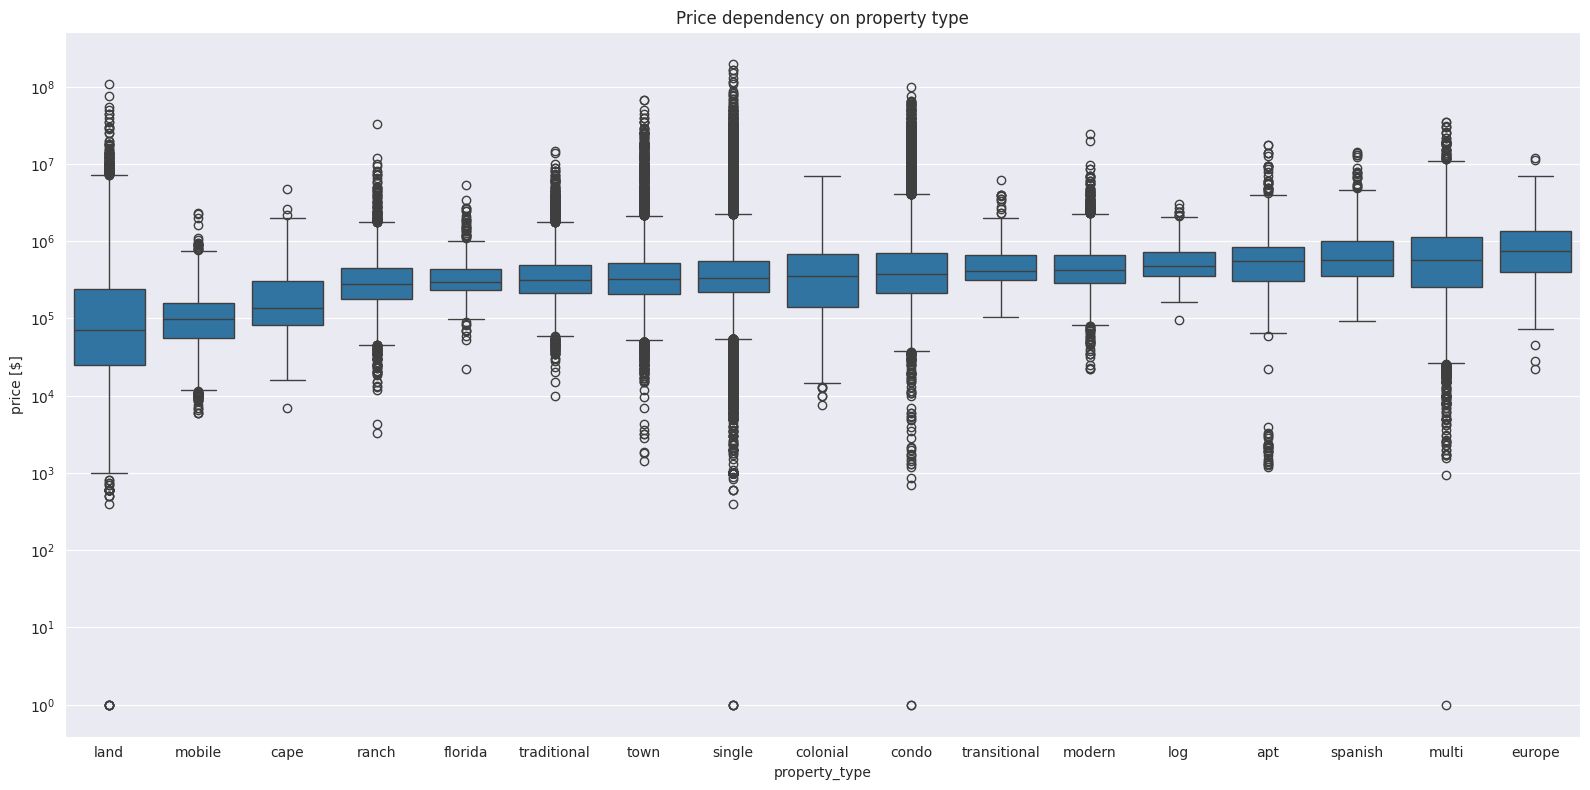

In [73]:
old_nums_cnt = df['propertyType'].isna().sum()
df = build_features.get_df_type(df)

new_none_percentage = utils.get_percentage(
    df['property_type'].isna().sum() - old_nums_cnt,
    old_nums_cnt
)
print(f'Количество "None" увеличилось на {new_none_percentage}')
display(df['property_type'].value_counts(dropna=False))

visualize.plot_boxplot(
    df,
    numeric_feature='target',
    categorical_feature='property_type',
    orient='v',
    log_scale=True,
    numeric_label='price [$]',
    title='Price dependency on property type',
    figsize=(16,8),
    ordered=True
);
plt.tight_layout()

- Количество пропусков увеличилось, но прежде всего засчёт неявных пропусков, а также уникальных малочисленных типов
- Ряд категорий впоследствии необходимо будет объединить, так как они малочисленны
- Мы видим, что дешевле всего объявления на землю, а также с "мобильными" домами.
- Далее идёт увеличение стоимости вплоть до испанского и европейского стилей.
- Есть ряд выбросов, которые впоследствии потребуется предобработать

## street, city, state, zipcode

На данном этапе "state" затрагивать не будем, посмотрим лишь для топовых штатов разницу в стоимости

state
FL    114570
TX     83269
NY     24329
CA     23170
NC     21768
TN     18218
WA     13730
OH     12423
IL      8823
NV      8402
GA      6632
CO      6371
PA      5493
MI      5119
DC      4581
AZ      3347
IN      3280
OR      2774
MA      1494
UT      1319
MD      1086
VT       864
MO       832
VA       800
WI       452
NJ       436
ME       258
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: count, dtype: int64

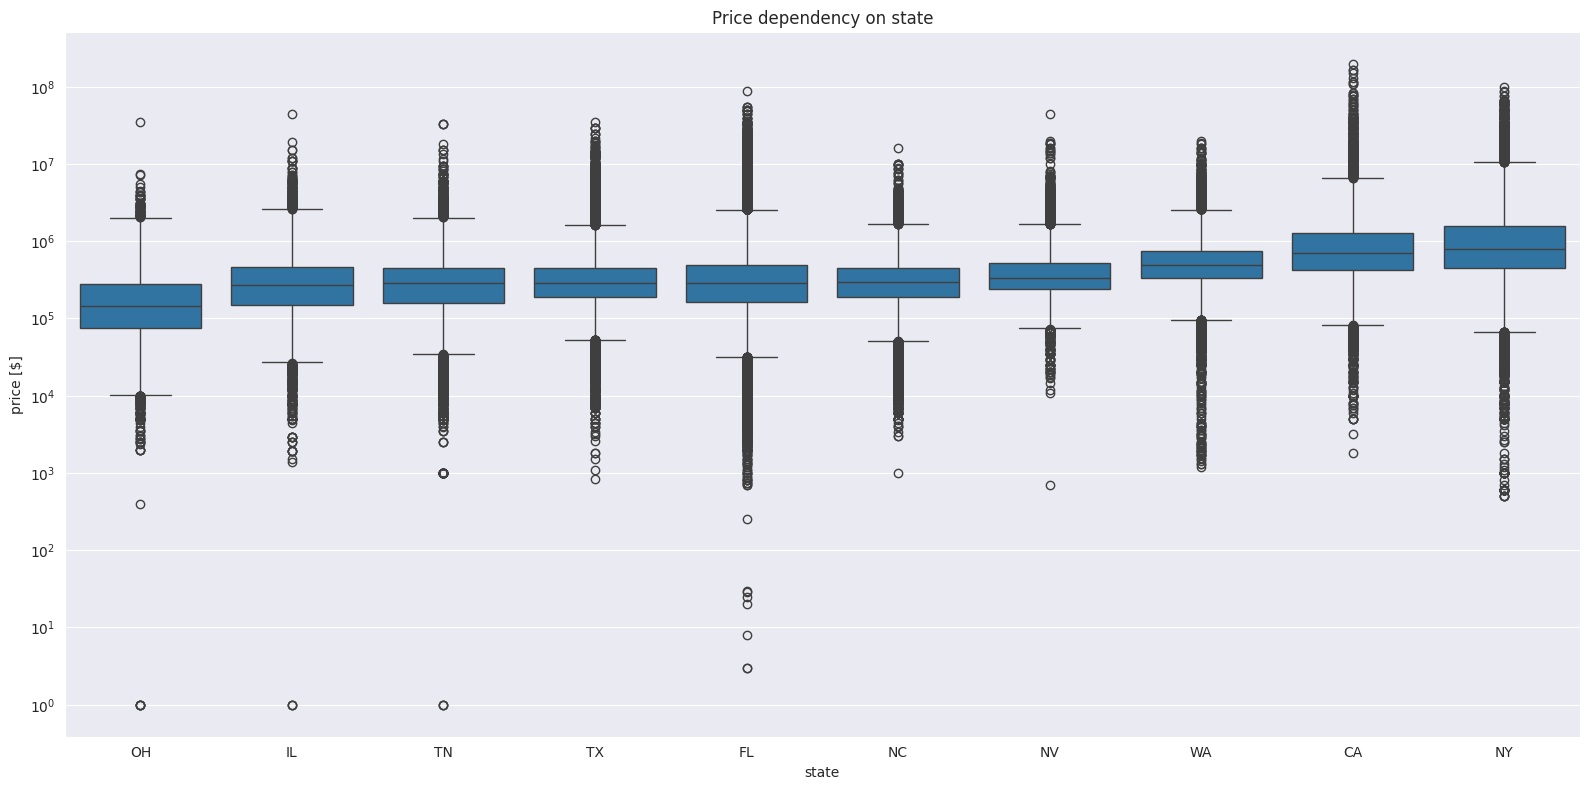

In [74]:
display(df['state'].value_counts())
visualize.plot_boxplot(
    df[df['state'].isin(df['state'].value_counts().index[:10])],
    numeric_feature='target',
    categorical_feature='state',
    orient='v',
    log_scale=True,
    numeric_label='price [$]',
    title='Price dependency on state',
    figsize=(16,8),
    ordered=True
);
plt.tight_layout()

Как и ожидалось, стоимость жилья зависит от штата.

In [75]:
df['zipcode'].value_counts().head(20)

zipcode
32137    2139
33131    1551
34747    1486
78245    1383
34759    1333
33132    1323
33137    1304
78253    1279
78254    1228
33130    1165
34746    1148
32164    1106
33160    1099
33133    1061
33308    1018
33178    1003
33141     982
77845     961
33140     954
33304     949
Name: count, dtype: int64

In [76]:
df['city'].value_counts().head(20)

city
Houston            24388
San Antonio        15496
Miami              15385
Jacksonville        9890
Dallas              8750
Brooklyn            7243
New York            6905
Chicago             6865
Charlotte           6517
Las Vegas           5959
Fort Worth          5474
Orlando             5156
Austin              5129
Fort Lauderdale     5072
Cleveland           5005
Nashville           4984
Philadelphia        4751
Tampa               4701
Washington          4581
Los Angeles         4151
Name: count, dtype: int64

In [77]:
street = df['street'].str.lower().str.strip()
disclosed_mask = street.str.contains('disclosed', na=False)
unavailable_mask = street.str.contains('available', na=False)
unknown_mask = street.str.contains('unknown', na=False)
display(
    df[
        disclosed_mask | unavailable_mask | unknown_mask
    ]['street'].value_counts()
)
df['street'] = build_features.get_street_feature(df['street'])

street
Address Not Disclosed    672
Undisclosed Address      516
(undisclosed Address)    391
Address Not Available    175
Unknown Address           72
Unknown                    2
41619 Re Undisclosed       2
61819 Undisclosed          2
Undisclosed Rd NE          1
112016 Rs Undisclosed      1
Unknown Rd #Lot Port       1
Name: count, dtype: int64

В улицах есть неявные пропуски. 
Остальные значения чересчур уникальны. Возможно, имеет смысл удалять.

## homeFacts и schools

Требуют отдельной обработки в другом ноутбуке - eda

# Export

In [78]:
display(df.info())
df.to_csv(export_path)

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                333918 non-null  object 
 1   street                372469 non-null  object 
 2   baths                 267467 non-null  float64
 3   homeFacts             374306 non-null  object 
 4   fireplace             374306 non-null  bool   
 5   city                  374272 non-null  object 
 6   schools               374306 non-null  object 
 7   sqft                  333384 non-null  float64
 8   zipcode               374306 non-null  object 
 9   beds                  277504 non-null  float64
 10  state                 374306 non-null  object 
 11  stories               221109 non-null  float64
 12  target                374306 non-null  int64  
 13  marked_interior_area  374306 non-null  bool   
 14  private_pool          374306 non-null  bool   
 15  mls  

None